In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
from pathlib import Path
import sys

# Library imports
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sc
from sklearn.metrics import mean_squared_error
import xarray as xr

# Util imports
sys.path.append("../../")
import src.climate_downscaling_utils as cd

# Correct station data

This notebook applies bias correction algorithms on gridded data using station data.

**Prerequisite**: Run `notebooks/02-apply-bias-correction/01_overlay_station.ipynb`

### Set input parameters

In [2]:
CITY_NAME = "Dagupan"
DATE = "2008-07-01"  # sample date for debugging
YEARS = [2007, 2008, 2009, 2016, 2017, 2018]
SHOULD_DEBUG = False
PROCESSED_PATH = Path("../../data/02-processed")
CORRECTED_PATH = PROCESSED_PATH / "bias-correction"

STATION_NC = CORRECTED_PATH / f"station_{CITY_NAME.lower()}.nc"
GRIDDED_NC = (
    PROCESSED_PATH
    / f"input/chirts_chirps_regridded_interpolated_{CITY_NAME.lower()}.nc"
)
GRIDDED_SUBSET_NC = CORRECTED_PATH / f"gridded_{CITY_NAME.lower()}.nc"

### Set run parameters
- `plot_offset`: margin for x and y bounds

In [18]:
variable_params = dict(
    tmin="CHIRTS minimum temperature",
    tmax="CHIRTS maximum temperature",
    precip="CHIRPS precipitation",
)

algo_params = [
    dict(
        name="Linear Scaling",
        func=cd.correct_gridded_cmethods,
        method="linear_scaling",
        group="time.month",
    ),
    dict(
        name="Variance Scaling",
        func=cd.correct_gridded_cmethods,
        method="variance_scaling",
        group="time.month",
    ),
    dict(
        name="Delta Method",
        func=cd.correct_gridded_cmethods,
        method="delta_method",
        group="time.month",
    ),
    dict(
        name="Quantile Mapping",
        func=cd.correct_gridded_cmethods,
        method="quantile_mapping",
        n_quantiles=1_000,
    ),
    # dict(
    #     name="Detrended Quantile Mapping", # got numpy error
    #     func=cd.correct_gridded_cmethods,
    #     method="detrended_quantile_mapping",
    #     n_quantiles=1_000,
    # ),
    dict(
        name="Quantile Delta Mapping",
        func=cd.correct_gridded_cmethods,
        method="quantile_delta_mapping",
        n_quantiles=1_000,
    ),
    # dict(
    #     name="Liu et al. (2019)",
    #     func=cd.correct_gridded_liu,
    # ),
    # dict(
    #    name="Z-Score",
    #    func=cd.correct_gridded_zscore,
    # ),
]

# refer to defaults
for algo_param in algo_params:
    if "group" not in algo_param.keys():
        algo_param["group"] = "time.month"
    if "n_quantiles" not in algo_param.keys():
        algo_param["n_quantiles"] = 1_000


scatterplot_params = dict(
    tmin=dict(
        variable_name="Minimum Temperature",
        units="°C",
        plot_offset=2.5,
        color="firebrick",
    ),
    tmax=dict(
        variable_name="Maximum Temperature",
        units="°C",
        plot_offset=1,
        color="firebrick",
    ),
    precip=dict(
        variable_name="Precipitation",
        units="mm/day",
        plot_offset=10,
        color="dodgerblue",
    ),
)

### Load data

In [4]:
station_ds = xr.open_dataset(STATION_NC, engine="scipy")
gridded_ds = xr.open_dataset(GRIDDED_NC, engine="scipy")
gridded_subset_ds = xr.open_dataset(GRIDDED_SUBSET_NC, engine="scipy")

In [5]:
gridded_subset_ds

<xarray.Dataset>
Dimensions:      (time: 7305, lat: 13, lon: 13)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2022-12-31
  * lon          (lon) float64 120.2 120.2 120.3 120.3 ... 120.4 120.4 120.5
  * lat          (lat) float64 15.97 15.99 16.01 16.03 ... 16.17 16.19 16.21
    band         int32 ...
    spatial_ref  int32 ...
Data variables:
    tmin         (time, lat, lon) float64 ...
    tmax         (time, lat, lon) float64 ...
    precip       (time, lat, lon) float64 ...
    elevation    (lat, lon) float64 ...
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

In [6]:
station_lat = station_ds["lat"].item()
station_lon = station_ds["lon"].item()

# Apply bias correction

In [7]:
gridded_ds.isel(time=gridded_ds.time.dt.year.isin(YEARS))

<xarray.Dataset>
Dimensions:      (time: 2192, lat: 25, lon: 27, band: 1)
Coordinates:
  * time         (time) datetime64[ns] 2007-01-01 2007-01-02 ... 2018-12-31
  * lon          (lon) float64 120.0 120.0 120.0 120.1 ... 120.5 120.5 120.5
  * lat          (lat) float64 15.91 15.93 15.95 15.97 ... 16.35 16.37 16.39
  * band         (band) int32 1
    spatial_ref  int32 ...
Data variables:
    tmin         (time, lat, lon, band) float64 ...
    tmax         (time, lat, lon, band) float64 ...
    precip       (time, lat, lon, band) float64 ...
    elevation    (band, lat, lon) float64 ...
Attributes: (12/16)
    Conventions:    CF-1.6
    title:          dataVersion 1.0
    history:        created by Climate Hazards Center
    version:        Version 1.0
    date_created:   2023-05-15
    creator_name:   Pete Peterson
    ...             ...
    website:        https://chc.ucsb.edu/data/chirtsmonthly    https://chc.uc...
    comments:       
    reference-1:    Funk, C. et al. A high-resolution 1983–2016 Tmax climate ...
    reference-2:    Verdin, A. et al. Development and validation of the CHIRT...
    reference-3:    Tuholske, C., Caylor, K., Funk, C., Verdin, A., Sweeney, ...
    regrid_method:  bilinear

In [8]:
stats_df = pd.DataFrame(columns=["var", "method", "corr", "pval", "rmse"])
stats_df

,var,method,corr,pval,rmse


In [20]:
stats_list = []
for var, title in variable_params.items():
    print(f"Now doing {title}")

    if var == "precip":
        gridded_da = gridded_ds.isel(time=gridded_ds.time.dt.year.isin(YEARS))[var]
        gridded_subset_da = gridded_subset_ds.isel(
            time=gridded_subset_ds.time.dt.year.isin(YEARS)
        )[var]
        station_da = station_ds.isel(time=station_ds.time.dt.year.isin(YEARS))[var]
    else:
        gridded_da = gridded_ds.isel(time=gridded_ds.time.dt.year.isin(YEARS))[var]  #
        gridded_subset_da = gridded_subset_ds.isel(
            time=gridded_subset_ds.time.dt.year.isin(YEARS)
        )[var]
        station_da = station_ds.isel(time=station_ds.time.dt.year.isin(YEARS))[var]

    if SHOULD_DEBUG:
        gridded_da.sel(time=DATE, method="nearest").plot()
        plt.plot(station_lon, station_lat, "o")
        plt.show()

        gridded_subset_da.sel(time=DATE, method="nearest").plot()
        plt.plot(station_lon, station_lat, "o")
        plt.show()

        gridded_subset_da.plot.hist(bins=15)
        plt.show()

    for algo_param in algo_params:
        print(f"Now doing {algo_param['name']} bias correction")

        if algo_param["name"] == "Liu et al. (2019)" or algo_param["name"] == "Z-Score":
            corrected_da = algo_param["func"](
                gridded_subset_da.sel(time=DATE, method="nearest"),
                station_da=station_da.sel(time=DATE, method="nearest"),
                std_scale=0.1,
                should_plot=SHOULD_DEBUG,
            )
        else:
            corrected_da = algo_param["func"](
                gridded_da=gridded_subset_da,
                station_da=station_da[:, 0, 0].drop_vars(["lat", "lon"]),
                method=algo_param["method"],
                n_quantiles=algo_param["n_quantiles"],
                group=algo_param["group"],
                should_plot=SHOULD_DEBUG,
            )

        station_aligned_da, corrected_aligned_da = xr.align(
            station_da.mean(dim=["lat", "lon"], skipna=True).dropna(dim="time"),
            corrected_da.mean(dim=["lat", "lon"], skipna=True).dropna(dim="time"),
            join="inner",
        )

        corr, pval = sc.pearsonr(station_aligned_da, corrected_aligned_da)
        rmse = mean_squared_error(
            station_aligned_da, corrected_aligned_da, squared=False
        )

        stats_list.append(
            dict(var=var, method=algo_param["method"], corr=corr, pval=pval, rmse=rmse)
        )

        if SHOULD_DEBUG:
            gridded_subset_slice_da = gridded_subset_da.sel(time=DATE, method="nearest")
            corrected_slice_da = corrected_da.sel(time=DATE, method="nearest")

            plot_min = min(
                [corrected_slice_da.min(), gridded_subset_slice_da.min()]
            ).values
            plot_max = max(
                [corrected_slice_da.max(), gridded_subset_slice_da.max()]
            ).values

            gridded_subset_slice_da.plot(vmin=plot_min, vmax=plot_max)
            plt.title(title)
            plt.show()

            corrected_slice_da.plot(vmin=plot_min, vmax=plot_max)
            plt.title(f"Corrected {title}\n{algo_param['name']}")
            plt.show()

            abs(corrected_slice_da - gridded_subset_slice_da).plot(cmap="RdYlGn")
            plt.title(
                f"Difference between corrected and uncorrected\n{title}\n{algo_param['name']}"
            )
            plt.show()
stats_df = pd.DataFrame(stats_list)

Now doing CHIRTS minimum temperature
Now doing Linear Scaling bias correction
Now doing Variance Scaling bias correction
Now doing Delta Method bias correction
Now doing Quantile Mapping bias correction
Now doing Quantile Delta Mapping bias correction
Now doing CHIRTS maximum temperature
Now doing Linear Scaling bias correction
Now doing Variance Scaling bias correction
Now doing Delta Method bias correction
Now doing Quantile Mapping bias correction
Now doing Quantile Delta Mapping bias correction
Now doing CHIRPS precipitation
Now doing Linear Scaling bias correction
Now doing Variance Scaling bias correction
Now doing Delta Method bias correction
Now doing Quantile Mapping bias correction
Now doing Quantile Delta Mapping bias correction


In [58]:
stats_df[["var", "method", "corr", "rmse"]]

,var,method,corr,rmse
0,tmin,linear_scaling,0.825009,1.003837e+00
1,tmin,variance_scaling,0.716508,1.224185e+00
2,tmin,delta_method,1.000000,1.396821e-15
3,tmin,quantile_mapping,0.709032,1.311964e+00
4,tmin,quantile_delta_mapping,0.709032,1.311964e+00
5,tmax,linear_scaling,0.826238,1.103731e+00
6,tmax,variance_scaling,0.544218,1.632147e+00
7,tmax,delta_method,1.000000,3.170027e-15
8,tmax,quantile_mapping,0.812930,1.207144e+00
9,tmax,quantile_delta_mapping,0.812930,1.207144e+00


<Axes: >

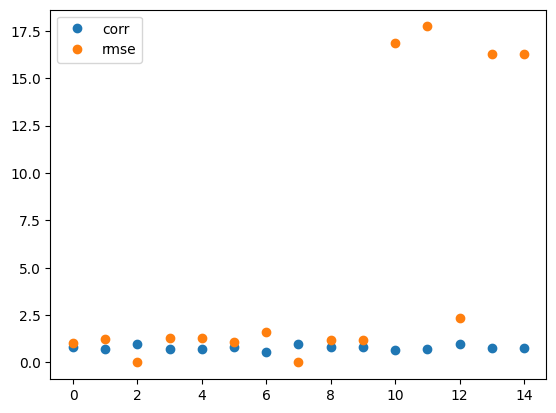

In [26]:
stats_df[["var", "method", "corr", "rmse"]].plot(marker="o", linestyle="")

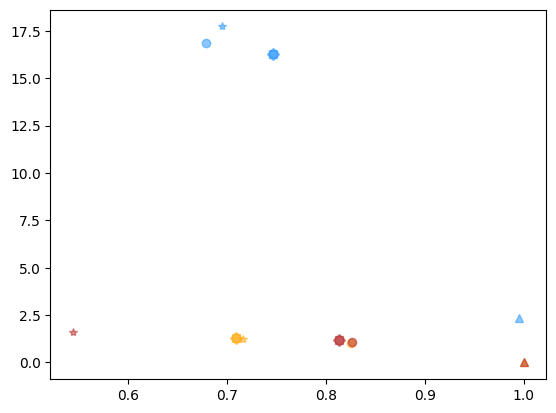

In [57]:
color_dict = dict(
    tmin="orange",
    tmax="firebrick",
    precip="dodgerblue",
)

method_dict = dict(
    linear_scaling="o",
    variance_scaling="*",
    delta_method="^",
    quantile_mapping="s",
    quantile_delta_mapping="D",
)

for var in stats_df["var"].unique():
    for method in stats_df["method"].unique():
        corr_n = stats_df.where(
            (stats_df["var"] == var) & (stats_df["method"] == method)
        ).dropna()["corr"]
        rmse_n = stats_df.where(
            (stats_df["var"] == var) & (stats_df["method"] == method)
        ).dropna()["rmse"]
        plt.plot(
            corr_n,
            rmse_n,
            marker=method_dict[method],
            color=color_dict[var],
            label=f"{var}-{method}",
            alpha=0.5,
        )
# plt.legend()
plt.show()

In [55]:
corr_n

0   NaN
Name: corr, dtype: float64

In [50]:
stats_df.where((stats_df["var"] == var) & (stats_df["method"] == method)).head(1)[
    "corr"
]

0    0.825009
Name: corr, dtype: float64

### Plot select dates

In [11]:
# for slice_date in [f"2008-{i:02d}-20" for i in range(7, 12 + 1)]:
#     print(slice_date)
#     gridded_subset_slice_da = gridded_subset_da.sel(time=slice_date)
#     corrected_slice_da = corrected_da.sel(time=slice_date)

#     plot_min = min([corrected_slice_da.min(), gridded_subset_slice_da.min()]).values
#     plot_max = max([corrected_slice_da.max(), gridded_subset_slice_da.max()]).values

#     gridded_subset_slice_da.plot(vmin=plot_min, vmax=plot_max)
#     plt.title(f"{slice_date}\n{title}")
#     plt.show()

#     corrected_slice_da.plot(vmin=plot_min, vmax=plot_max)
#     plt.title(
#         f"{slice_date}\nCorrected {title}\n{algo_param['name']}\nStation reading: {station_da.sel(time=slice_date).mean().item()}"
#     )
#     plt.show()

#     (corrected_slice_da - gridded_subset_slice_da).plot(cmap="RdYlGn")
#     plt.title(
#         f"{slice_date}\nDifference between corrected and uncorrected\n{title}\n{algo_param['name']}"
#     )
#     plt.show()

### Scatterplot

In [12]:
# station_aligned_da, corrected_aligned_da = xr.align(
#     station_da.mean(dim=["lat", "lon"], skipna=True).dropna(dim="time"),
#     corrected_da.mean(dim=["lat", "lon"], skipna=True).dropna(dim="time"),
#     join="inner",
# )

# corr, pval = sc.pearsonr(station_aligned_da, corrected_aligned_da)
# rmse = mean_squared_error(station_aligned_da, corrected_aligned_da, squared=False)

# fig, ax = plt.subplots(1, 1)
# plot_min = min(station_aligned_da.min(), corrected_aligned_da.min()) - scatterplot_params[var]["plot_offset"]
# plot_max = max(station_aligned_da.max(), corrected_aligned_da.max()) + scatterplot_params[var]["plot_offset"]
# ax.plot(
#     [plot_min - scatterplot_params[var]["plot_offset"], plot_max + scatterplot_params[var]["plot_offset"]],
#     [plot_min - scatterplot_params[var]["plot_offset"], plot_max + scatterplot_params[var]["plot_offset"]],
#     "k-",
# )
# ax.plot(station_aligned_da, corrected_aligned_da, "o", color=scatterplot_params[var]["color"])
# ax.set_aspect(1)
# plt.xlabel(f"Station {scatterplot_params[var]['variable_name']} ({scatterplot_params[var]['units']})")
# plt.ylabel(f"Corrected {scatterplot_params[var]['variable_name']} ({scatterplot_params[var]['units']})")
# plt.title(
#     f"Scatterplot of Corrected vs. Station {scatterplot_params[var]['variable_name']}\ncorr: {corr:.3f} pval: {pval:.3f}\nrmse: {rmse:.3f} {scatterplot_params[var]['units']}"
# )
# plt.xlim(plot_min, plot_max)
# plt.ylim(plot_min, plot_max)
# plt.show()

In [13]:
# df_time = station_aligned_da["time"].to_pandas().reset_index()
# df_time["year_month"] = pd.to_datetime(df_time["time"], format="%Y-%m-%d").dt.strftime("%Y-%m")
# df_time["year_month"].unique()